In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNetCV, LassoCV, Ridge
from sklearn import ensemble
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

### 1. Load the training data

In [2]:
df_dummy = pd.read_csv('dataset/complete_storage.csv')
df_dummy.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df_dummy.shape

(2719, 18)

In [4]:
df_dummy.columns

Index(['zip', 'area', 'market', 'state', 'city', 'lat', 'lng', 'population',
       'density', 'county', 'mean_income', 'mean_rent', 'change_in_emprate',
       'market_latitude', 'market_longitude', 'city_coord', 'market_coord',
       'distance'],
      dtype='object')

In [5]:
df = df_dummy[['market','state','county','city','zip','area','population','mean_income','mean_rent','change_in_emprate','density']]
df.rename(columns={'area':'storage_area'}, inplace=True)


In [6]:
df.head()

,market,state,county,city,zip,storage_area,population,mean_income,mean_rent,change_in_emprate,density
0,worcester - springfield,MA,hampden,chicopee,1020,72605.0,30097.0,63987.5,988.500000,0.846922,914.6
1,worcester - springfield,MA,hampden,springfield,1129,89250.0,6762.0,63987.5,988.500000,0.846922,790.8
2,worcester - springfield,MA,franklin,greenfield,1301,49500.0,17713.0,61561.0,904.000000,1.197479,268.1
3,worcester - springfield,MA,worcester,leominster,1453,71840.0,41579.0,55125.0,917.666667,0.582158,554.3
4,worcester - springfield,MA,worcester,auburn,1501,159485.0,16549.0,77291.0,1063.000000,0.582158,401.4


In [7]:
df.shape

(2719, 11)

### 2. Split data into test and train

In [8]:
y=np.log(df.storage_area) 
features=df.drop(['storage_area'],axis=1) 
X=pd.get_dummies(features, drop_first=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state = 42, test_size = 0.2)

In [10]:
print(X_test.shape,X_train.shape)

(544, 1751) (2175, 1751)


In [11]:
print(y_test.shape,y_train.shape)

(544,) (2175,)


### 3. Define the evaluation function

In [12]:
def evaluate(model, test_features, test_labels, train_features, train_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('the goodness of fit r square for the train dateset is:',model.score(train_features, train_labels))
    print('the goodness of fit r square for the test dateset is:',r2_score(test_labels, predictions))
    print('the RMSE is: ', np.sqrt(mean_squared_error(test_labels, predictions)))

### 4. Models and Result

#### 1. Regression Models

In [13]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)
evaluate(model,X_test, y_test, X_train, y_train)

Model Performance
Average Error: 0.6489 degrees.
Accuracy = 94.40%.
the goodness of fit r square for the train dateset is: 0.6365170327833329
the goodness of fit r square for the test dateset is: -1.1253571128644002
the RMSE is:  0.9168318442419031


#### 2. Regularization Models (Lasso and Ridge)

#### a) Lasso

In [14]:
lasso = LassoCV(alphas = None, max_iter = 50000, cv = 10, normalize = True)
lasso.fit(X_train,y_train)
print('The Lasso lambda is:',lasso.alpha_)
evaluate(lasso,X_test, y_test, X_train, y_train)

The Lasso lambda is: 0.0005485167031797739
Model Performance
Average Error: 0.4861 degrees.
Accuracy = 95.82%.
the goodness of fit r square for the train dateset is: 0.1666844381867667
the goodness of fit r square for the test dateset is: 0.09671024826929908
the RMSE is:  0.597705530444765


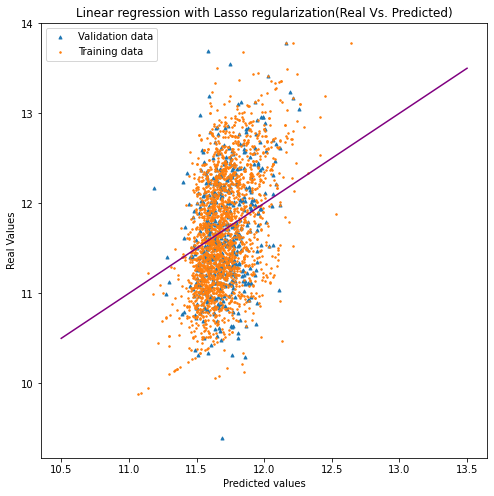

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(lasso.predict(X_test) , y_test,marker = "^", label = "Validation data", s=9) 
plt.scatter(lasso.predict(X_train), y_train,marker = ".", label = 'Training data', s=9)
plt.title("Linear regression with Lasso regularization(Real Vs. Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "purple")
plt.show()

##### Plot feature importance (the magnitude of features in the regression funciton)

Lasso picked 98 features and eliminated the other 1653 features


Text(0.5, 0, 'Coefficents')

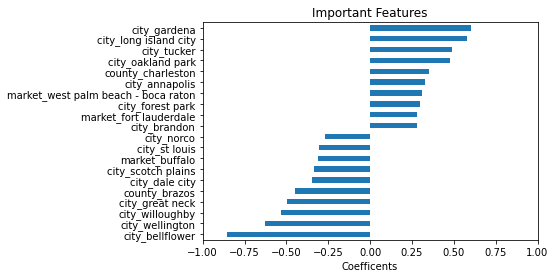

In [16]:

coefs = pd.Series(lasso.coef_, index = X_train.columns)
top_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
top_coefs.plot(kind = 'barh')
plt.title('Important Features')
plt.xlim(-1,1)
plt.xlabel('Coefficents')

##### Coefficient change with alpha

In [17]:

lasso = linear_model.Lasso(normalize=True)
alphas_lasso = np.logspace(-5, -1, 100)
coef_lasso = [] #going to get one coef_ value for each alpha
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train,y_train)
    coef_lasso.append(lasso.coef_)

Text(0, 0.5, 'coefficients')

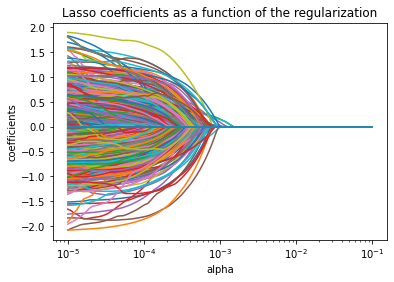

In [18]:
title = 'Lasso coefficients as a function of the regularization'
columns = X_train.columns
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')

#### b) Ridge

In [19]:
alphas_ridge = np.logspace(-5, 2, 100)
ridge = RidgeCV(alphas = alphas_ridge, cv = 10, normalize = True)
ridge.fit(X_train,y_train)
print('The ridge lambda is:',ridge.alpha_)
evaluate(ridge,X_test, y_test, X_train, y_train)

The ridge lambda is: 2.782559402207126
Model Performance
Average Error: 0.4874 degrees.
Accuracy = 95.82%.
the goodness of fit r square for the train dateset is: 0.3552974251960439
the goodness of fit r square for the test dateset is: 0.09366681769030372
the RMSE is:  0.5987116005458782


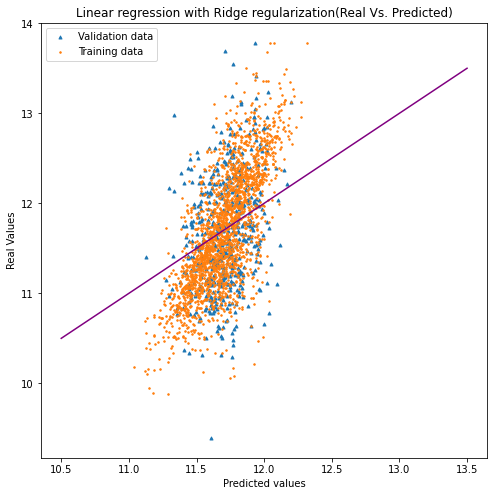

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(ridge.predict(X_test) , y_test,marker = "^", label = "Validation data", s=9) 
plt.scatter(ridge.predict(X_train), y_train,marker = ".", label = 'Training data', s=9)
plt.title("Linear regression with Ridge regularization(Real Vs. Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "purple")
plt.show()

ridge picked 1552 features and eliminated the other 199 features


Text(0.5, 0, 'Coefficents')

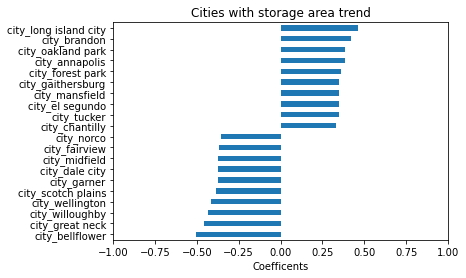

In [21]:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
top_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
print("ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
top_coefs.plot(kind = 'barh')
plt.title('Cities with storage area trend')
plt.xlim(-1,1)
plt.xlabel('Coefficents')

#### Coefficient change with alpha

In [22]:
ridge = linear_model.Ridge(normalize=True)
alphas_ridge = np.logspace(-3, 3, 100)
coef_ridge = []
for i in alphas_ridge:
    ridge.set_params(alpha=i).fit(X_train,y_train)
    coef_ridge.append(ridge.coef_)

Text(0, 0.5, 'coefficients')

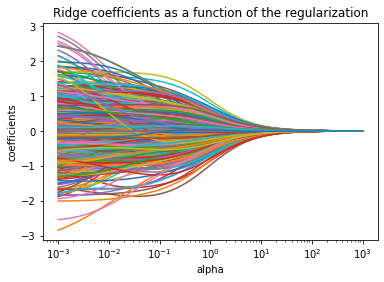

In [23]:
title = 'Ridge coefficients as a function of the regularization'
columns = X_train.columns
df_coef = pd.DataFrame(coef_ridge, index=alphas_ridge, columns=columns)
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')

#### b) ElasticNet

In [24]:
elastic = ElasticNetCV(alphas = None, max_iter = 50000, cv = 10, normalize = True)
elastic.fit(X_train,y_train)
print('The elastic lambda is:',elastic.alpha_)
evaluate(elastic,X_test, y_test, X_train, y_train)

The elastic lambda is: 0.0006731295257258783
Model Performance
Average Error: 0.4856 degrees.
Accuracy = 95.83%.
the goodness of fit r square for the train dateset is: 0.23654094749479426
the goodness of fit r square for the test dateset is: 0.1016711138955475
the RMSE is:  0.5960619719054232


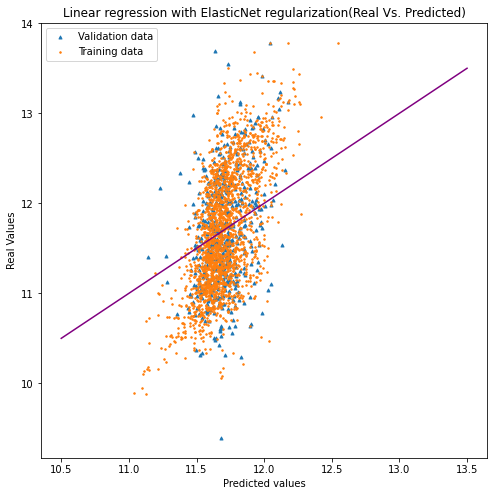

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(elastic.predict(X_test) , y_test,marker = "^", label = "Validation data", s=9) 
plt.scatter(elastic.predict(X_train), y_train,marker = ".", label = 'Training data', s=9)
plt.title("Linear regression with ElasticNet regularization(Real Vs. Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "purple")
plt.show()

ElasticNet picked 410 features and eliminated the other 1341 features


Text(0.5, 0, 'Coefficents')

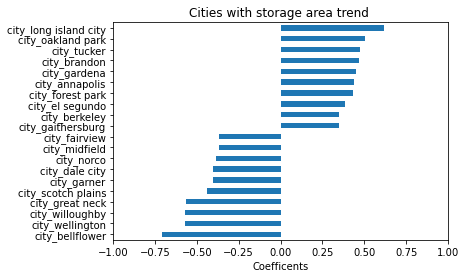

In [26]:
coefs = pd.Series(elastic.coef_, index = X_train.columns)
top_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
top_coefs.plot(kind = 'barh')
plt.title('Cities with storage area trend ')
plt.xlim(-1,1)
plt.xlabel('Coefficents')

#### coefficient change with alpha

In [27]:
elastic = linear_model.ElasticNet(normalize=True)
alphas_elastic = np.logspace(-5, -1, 100)
coef_elastic = [] 
for i in alphas_elastic:
    elastic.set_params(alpha=i).fit(X_train,y_train)
    coef_elastic.append(elastic.coef_)

Text(0, 0.5, 'coefficients')

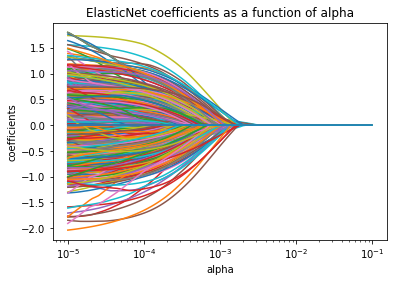

In [28]:
title = 'ElasticNet coefficients as a function of alpha'
columns = X_train.columns
df_coef = pd.DataFrame(coef_elastic, index=alphas_elastic, columns=columns)
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')

###  Tree models

#### Base Model - Random Forest

In [29]:
base_model = ensemble.RandomForestRegressor(n_estimators = 100, random_state = 42, max_features=
                                           150, max_depth=25)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test, X_train, y_train)

Model Performance
Average Error: 0.4714 degrees.
Accuracy = 95.94%.
the goodness of fit r square for the train dateset is: 0.6591353783086837
the goodness of fit r square for the test dateset is: 0.15008193992223828
the RMSE is:  0.5797787073977927


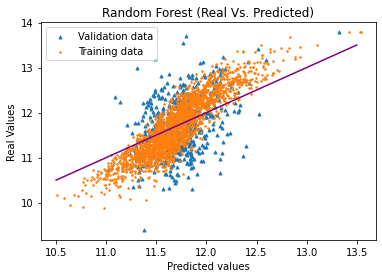

In [30]:
plt.scatter(base_model.predict(X_test) , y_test,marker = "^", label = "Validation data", s=9) 
plt.scatter(base_model.predict(X_train), y_train,marker = ".", label = 'Training data', s=9)
plt.title("Random Forest (Real Vs. Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "purple")
plt.show()

Text(0, 0.5, 'Features')

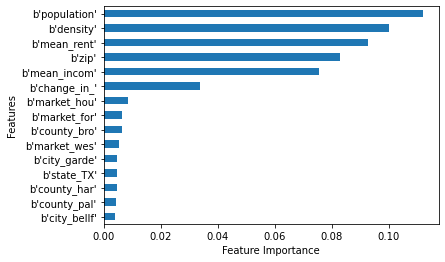

In [31]:
feature_importance_base = list(zip(X.columns, base_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_base = np.array(feature_importance_base, dtype=dtype)
feature_sort_base = np.sort(feature_importance_base, order='importance')[::-1]
name, score = zip(*list(feature_sort_base))
pd.DataFrame({'name':name,'score':score})[:15].sort_values('score').plot.barh(x='name', y='score', legend=None)
plt.xlabel('Feature Importance')
plt.ylabel('Features')

In [32]:
randomForest=ensemble.RandomForestRegressor()
n_trees_range = range(30, 200, 10)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []
oob_error = []

for n_trees in n_trees_range:
    randomForest.set_params(n_estimators=n_trees, random_state=42, oob_score=True)
    randomForest.fit(X_train, y_train)
    train_error2.append(1 - randomForest.score(X_train, y_train))
    test_error2.append(1 - randomForest.score(X_test, y_test))
    oob_error.append(1 - randomForest.oob_score_)

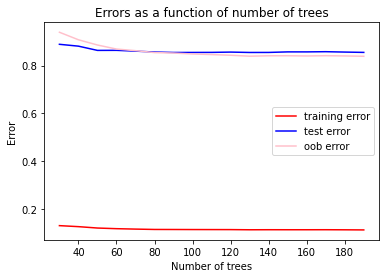

In [33]:

plt.plot(n_trees_range, train_error2, c='red', label='training error')
plt.plot(n_trees_range, test_error2, c='blue', label='test error')
plt.plot(n_trees_range, oob_error, c='pink', label='oob error')
plt.ylabel('Error')
plt.xlabel('Number of trees')
plt.title('Errors as a function of number of trees')
plt.legend()
plt.show()

#### b) XGboost

In [34]:
model = XGBRegressor(learning_rate=0.08, max_depth=4, n_estimators=298)
model.fit(X_train,y_train)
XGboost_accuracy = evaluate(model, X_test, y_test, X_train, y_train)

Model Performance
Average Error: 0.4812 degrees.
Accuracy = 95.86%.
the goodness of fit r square for the train dateset is: 0.45171544123985774
the goodness of fit r square for the test dateset is: 0.12535567783971124
the RMSE is:  0.5881518581305839


In [35]:
model = XGBRegressor(learning_rate=0.08, max_depth=4, n_estimators=298)
model.fit(X_train,y_train)
preds = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.5881518581305839

Text(0, 0.5, 'Feature')

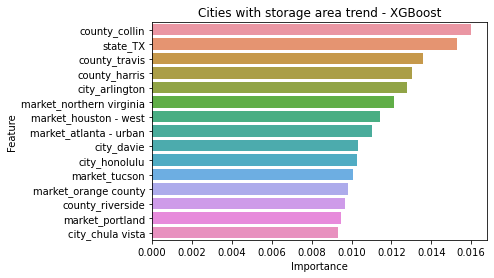

In [36]:
imp = pd.DataFrame({'Variable':X_train.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Variable', data=imp.head(15))
plt.title('Cities with storage area trend - XGBoost')
plt.ylabel('Feature')

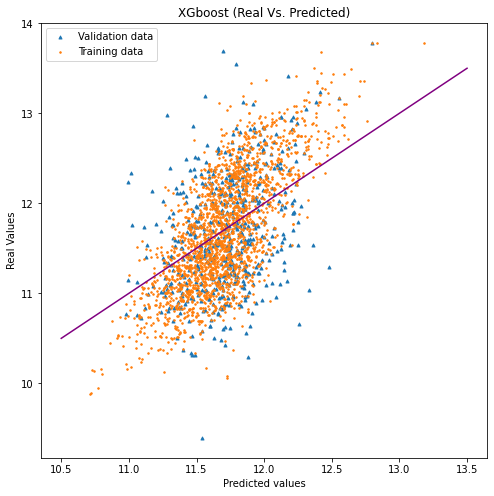

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(model.predict(X_test) , y_test,marker = "^", label = "Validation data", s=9) 
plt.scatter(model.predict(X_train), y_train,marker = ".", label = 'Training data', s=9)
plt.title("XGboost (Real Vs. Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "purple")
plt.show()

#### 4. KNN

In [38]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
Kmodel = KNeighborsRegressor(algorithm='auto', leaf_size=15, n_neighbors=4, p=1, weights='distance')
Kmodel.fit(rescaledX, y_train)
XGboost_accuracy = evaluate(Kmodel, X_test, y_test, X_train, y_train)

Model Performance
Average Error: 0.5740 degrees.
Accuracy = 95.01%.
the goodness of fit r square for the train dateset is: -0.1551833430007723
the goodness of fit r square for the test dateset is: -0.2324382095924602
the RMSE is:  0.6981621654685165
